In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [70]:
from scipy.stats import normaltest

samples = np.random.normal(size=1000, loc=0, scale=1)

result = normaltest(samples)

print(f"p-value: {result.pvalue}")
print(f"statistic: {result.statistic}")
print(f"The data is {'not ' if result.pvalue < 0.05 else ''}normally distributed")


p-value: 0.8519051247370295
statistic: 0.3205602285916163
The data is normally distributed


In [71]:
from src.dataset import load_team_data, load_agg_player_data
from src.preprocessing import impute_missing_values, split_data, remove_name_columns, encode_target_variable, remove_na_columns, find_knee_point

team_statistics, y = load_team_data()
player_statistics = load_agg_player_data()
x = pd.concat([team_statistics, player_statistics], axis=1, join='inner')

x = remove_name_columns(x)
y = encode_target_variable(y)
(x_train, y_train), (x_val, y_val), (x_test, y_test) = split_data(x, y)

x_train, imputer, numeric_columns = impute_missing_values(x_train)
x_val, _, _ = impute_missing_values(x_val, imputer=imputer, numeric_columns=numeric_columns)
x_test, _, _ = impute_missing_values(x_test, imputer=imputer, numeric_columns=numeric_columns)

x_train, non_na_columns = remove_na_columns(x_train)
x_val, _ = remove_na_columns(x_val, non_na_columns=non_na_columns)
x_test, _ = remove_na_columns(x_test, non_na_columns=non_na_columns)

y_train = y_train.to_numpy().flatten()
y_val = y_val.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()

In [72]:
# x_train_clean = x_train.copy()
# x_val_clean = x_val.copy()
# x_test_clean = x_test.copy()

In [73]:
x_train = x_train_clean.copy()
x_val = x_val_clean.copy()
x_test = x_test_clean.copy()

In [74]:
# === Load mutual information feature ===
scores = np.load("features_importance_mutual_info_based.npy")

order = np.argsort(scores)[::-1]
scores_sorted = scores[order]

k = 10
knee_indices = [find_knee_point(scores_sorted)]

for i in range(k-1):
    knee_indices.append(find_knee_point(scores_sorted[knee_indices[i]:]) + knee_indices[i])
# =======================================
    
# === Extract best features ===
index_knee = 2
columns_selected = x_train.columns[order[:knee_indices[index_knee]]]

features = list(columns_selected)
features = set([feature[5:] for feature in features])

columns_to_keep = ["HOME_" + feature for feature in features] + ["AWAY_" + feature for feature in features]

x_train = x_train[columns_to_keep]
x_val = x_val[columns_to_keep]
x_test = x_test[columns_to_keep]
# =============================

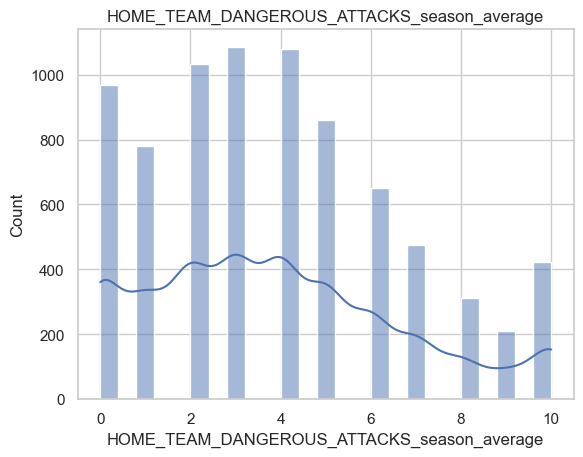

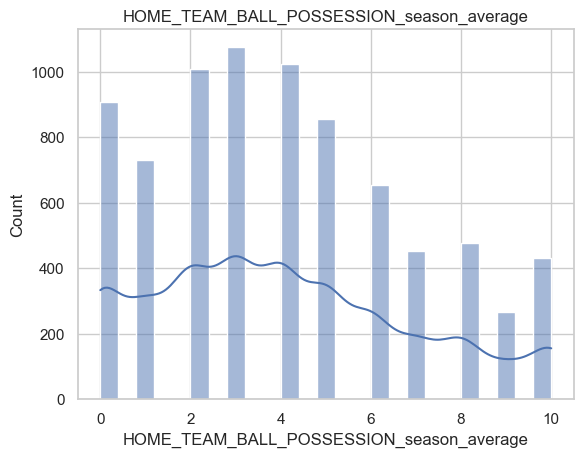

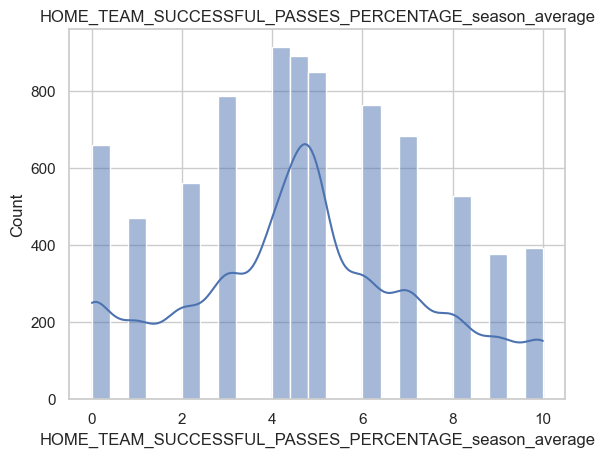

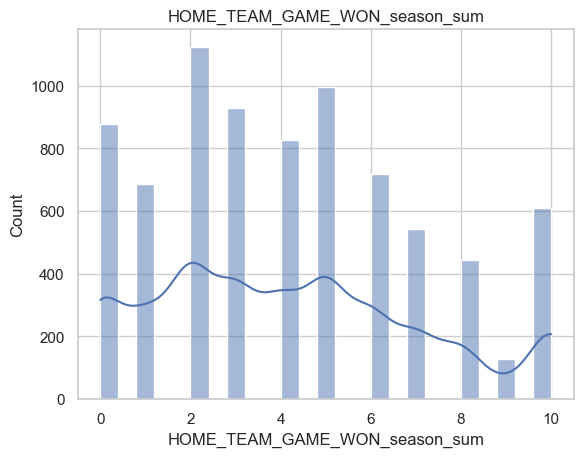

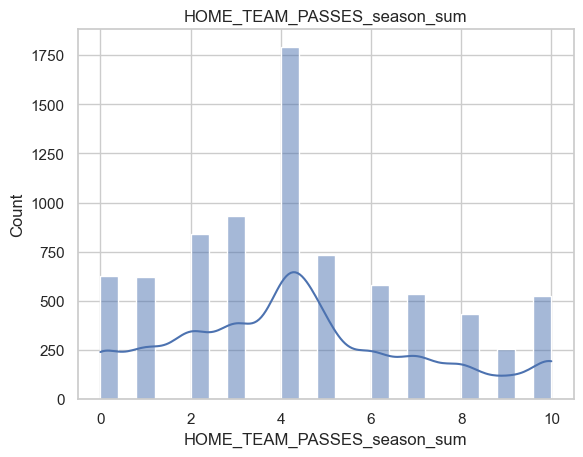

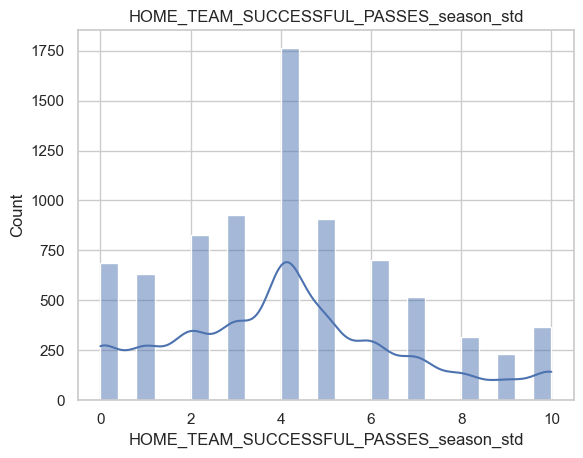

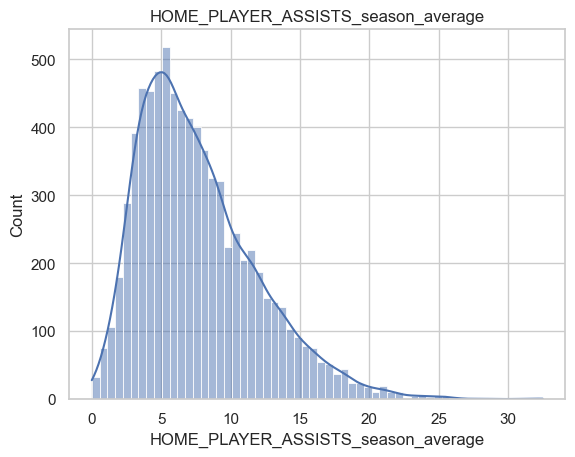

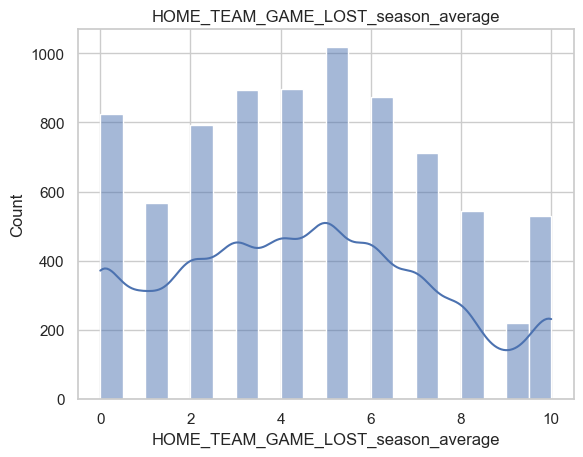

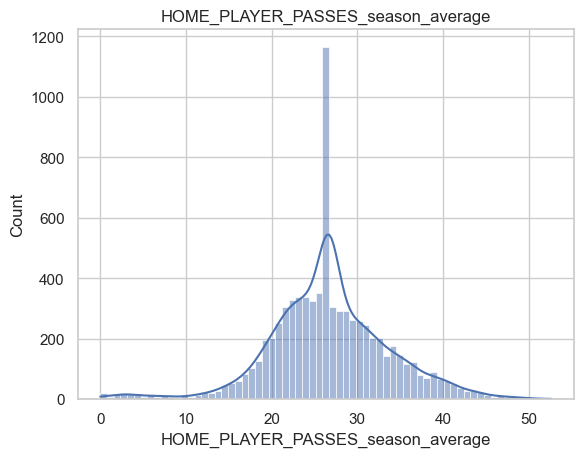

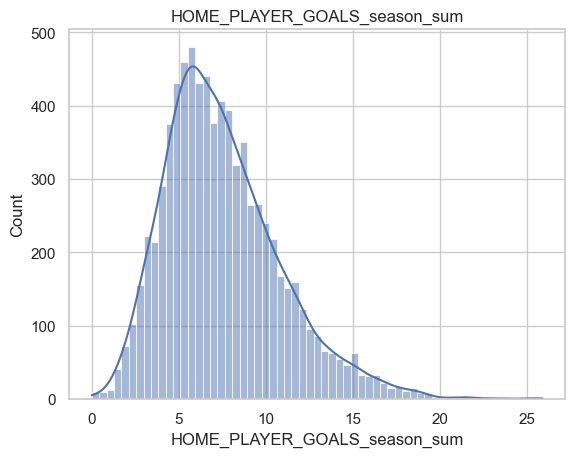

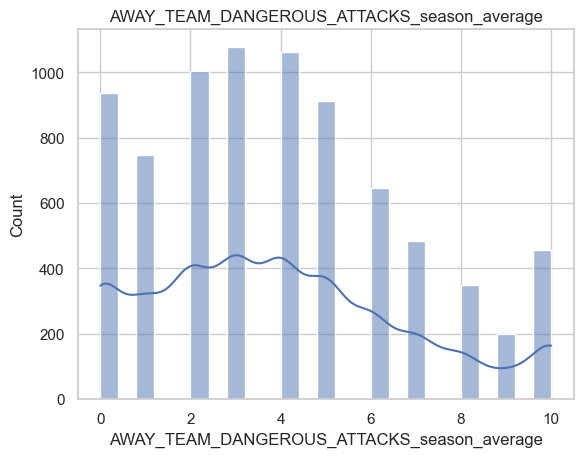

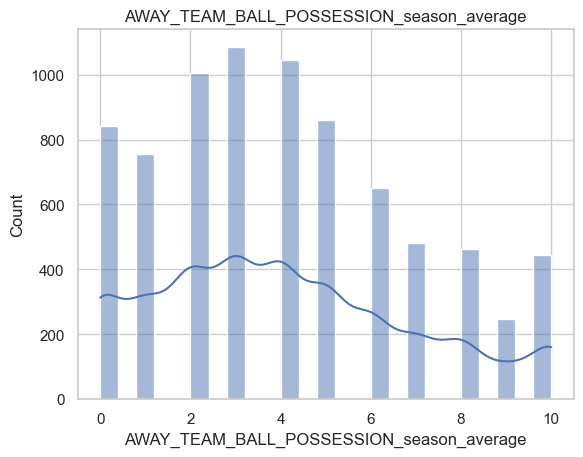

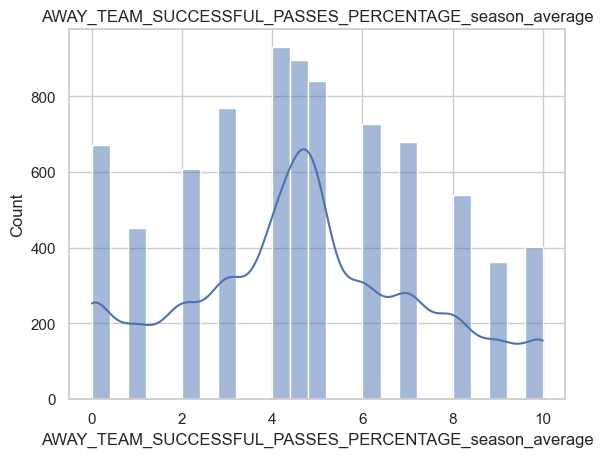

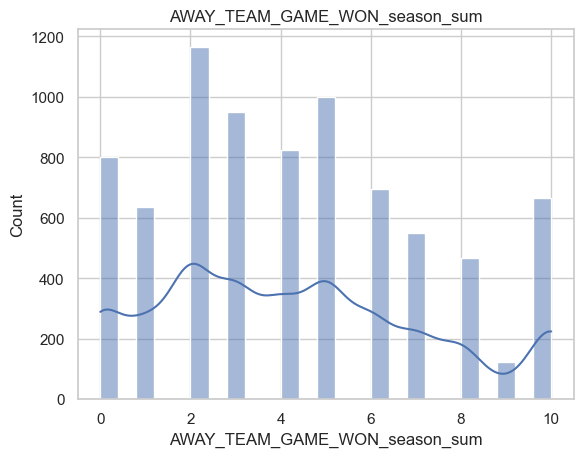

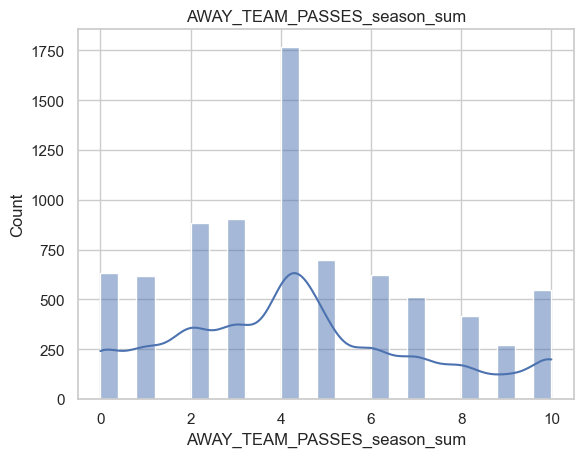

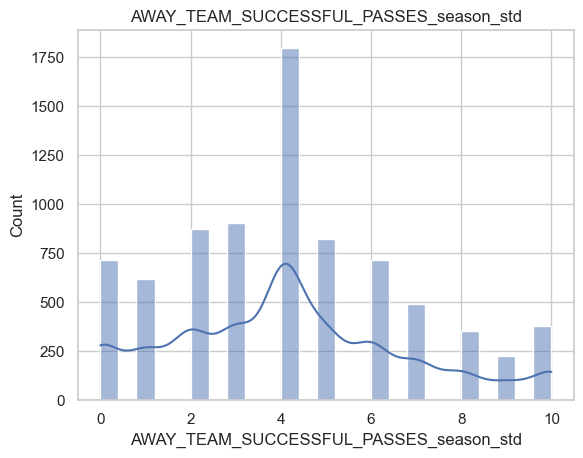

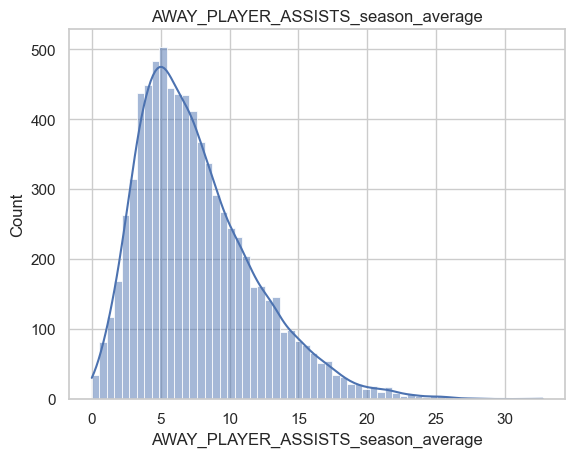

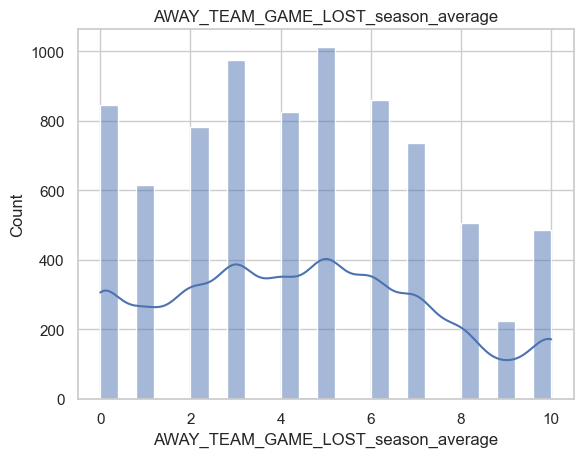

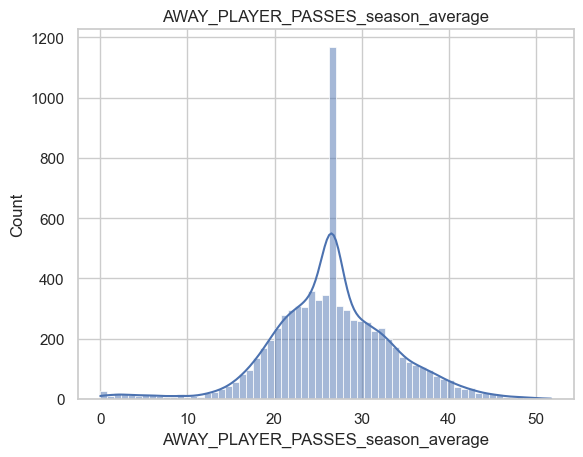

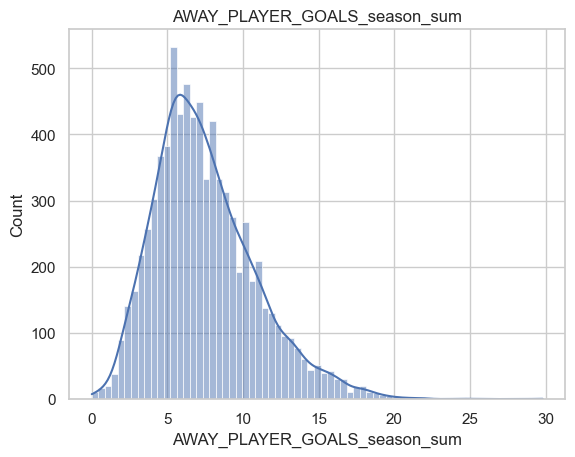

In [79]:
# plot each feature
for feature in columns_to_keep:
    plt.figure()
    sns.histplot(x_train[feature], kde=True, fill=True)
    plt.title(feature)
    plt.show()

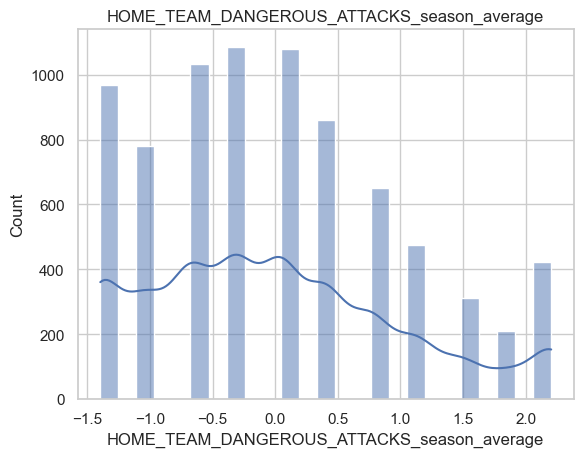

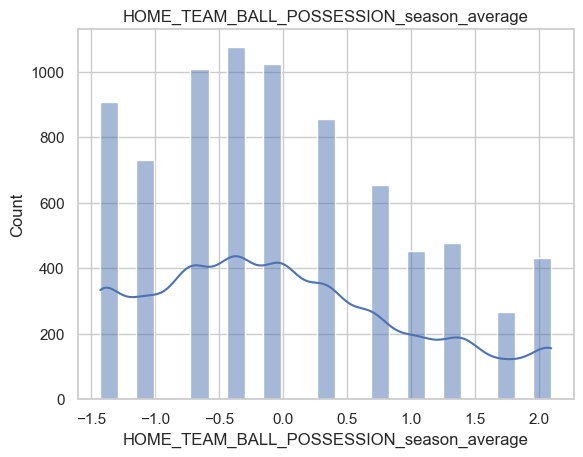

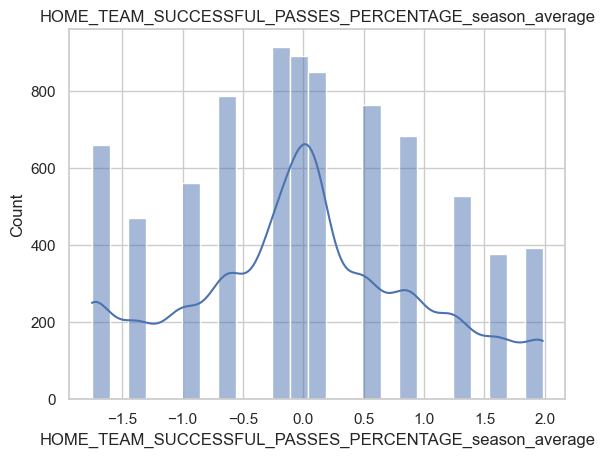

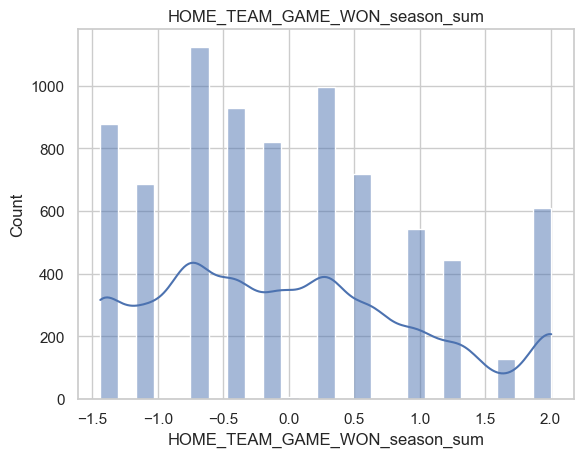

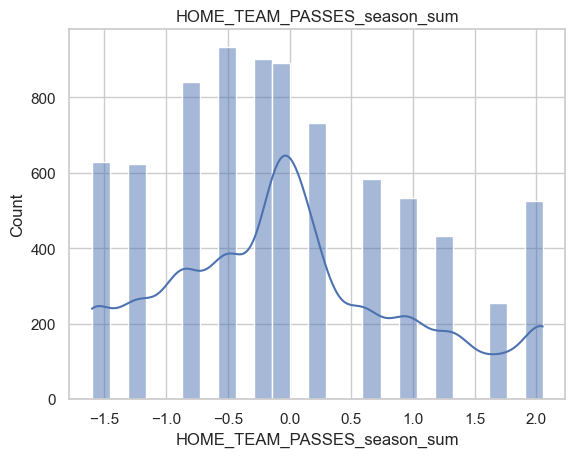

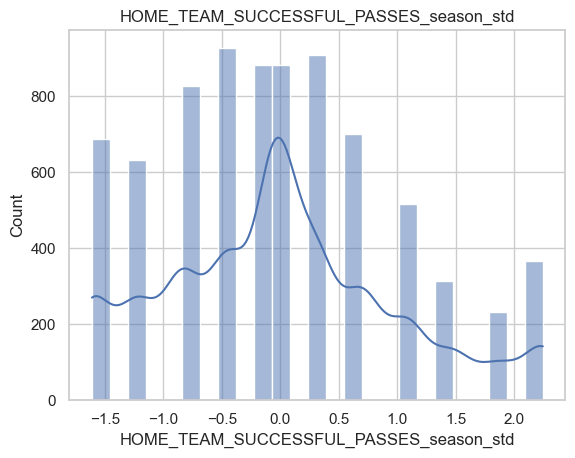

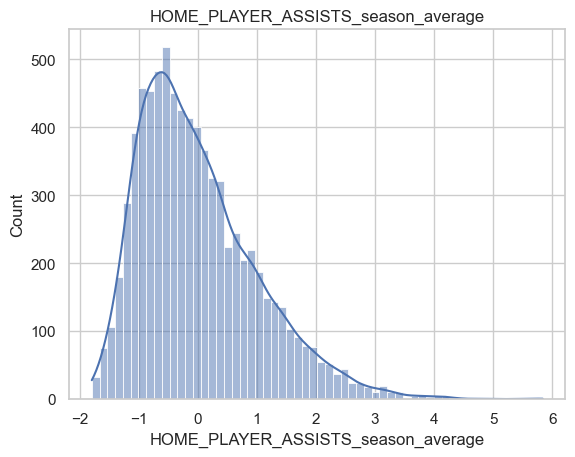

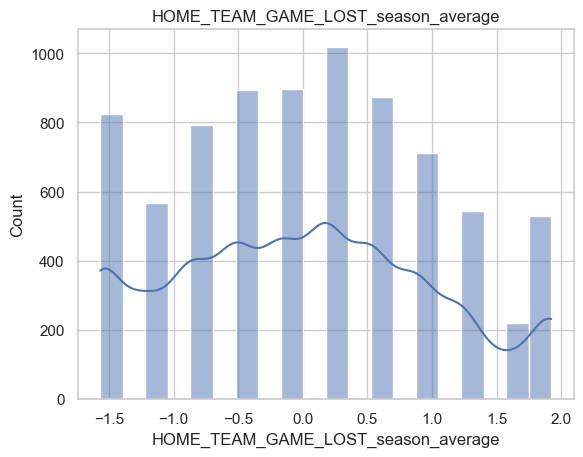

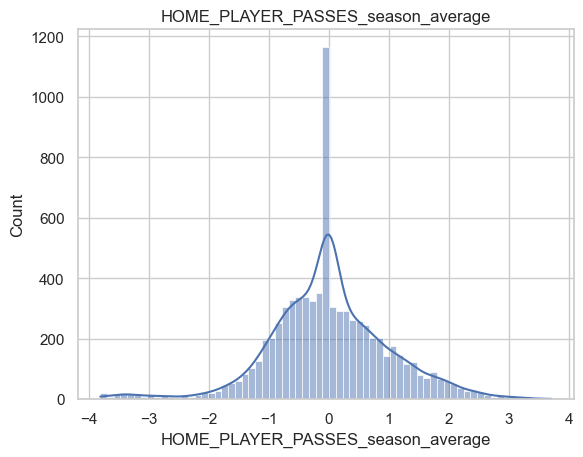

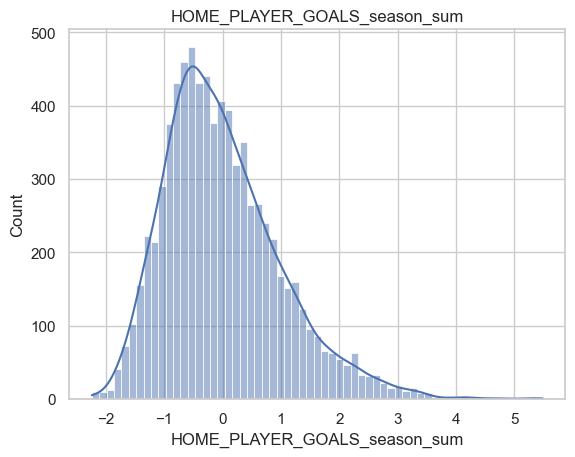

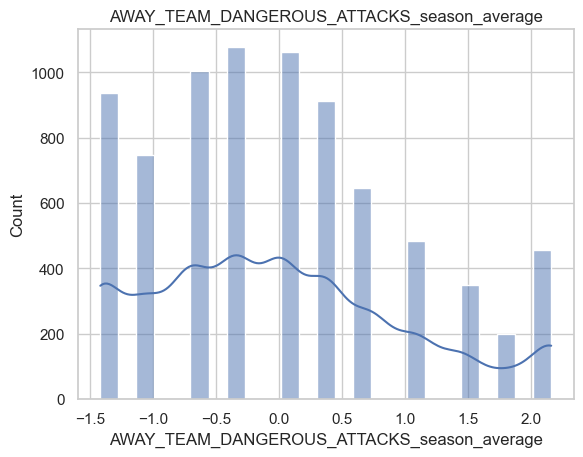

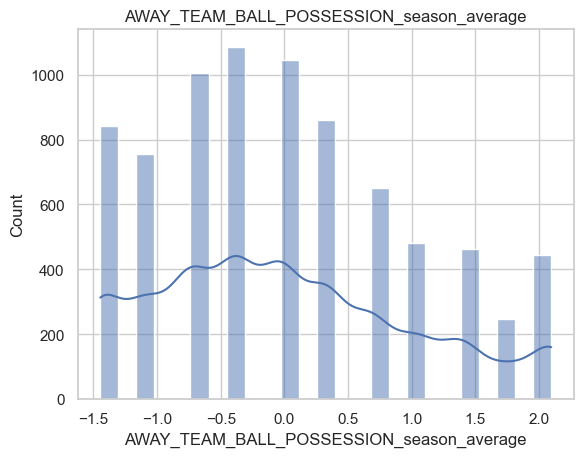

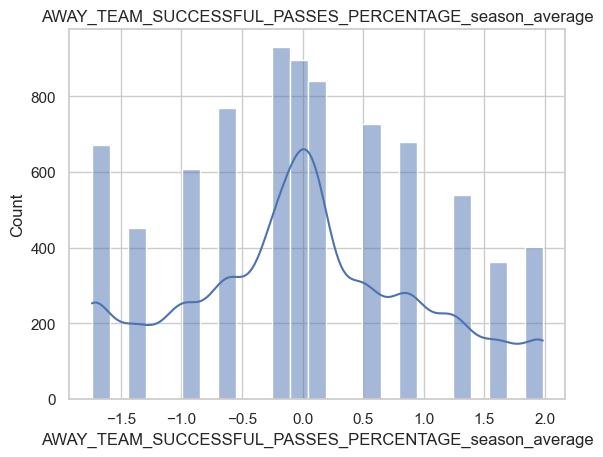

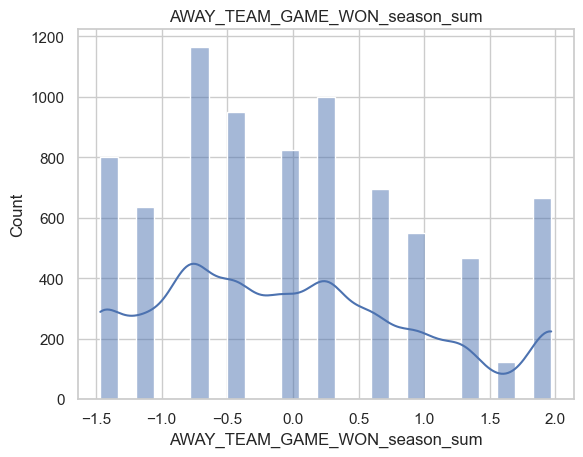

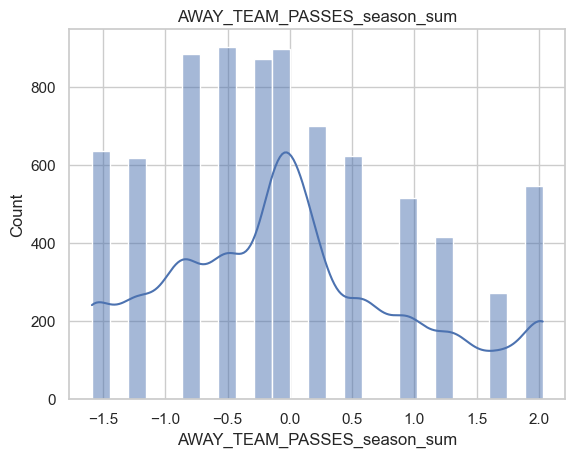

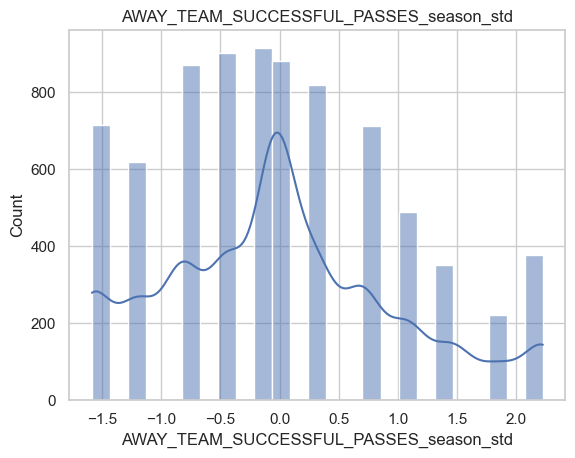

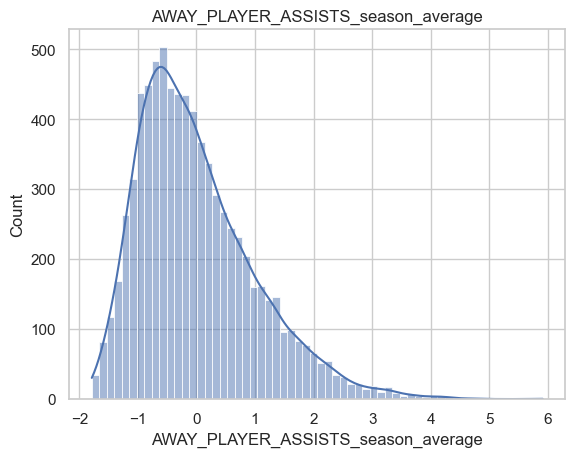

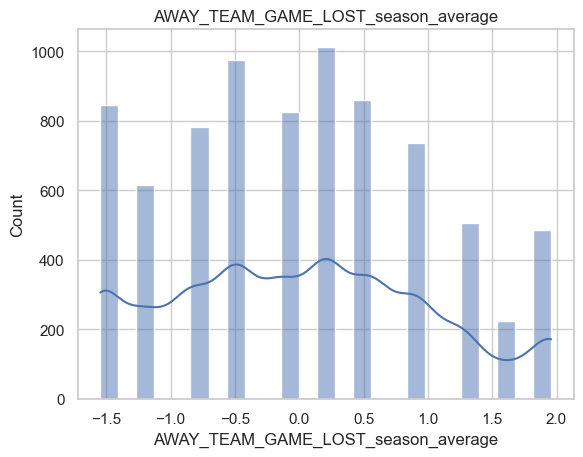

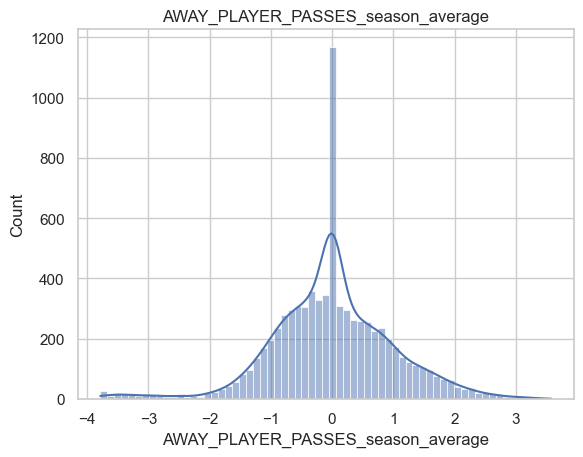

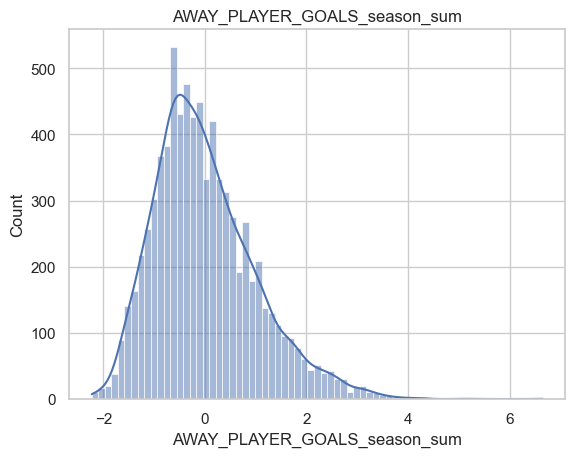

In [80]:
# normalise each feature
for feature in columns_to_keep:
    x_train[feature] = (x_train[feature] - x_train[feature].mean()) / x_train[feature].std()
    x_val[feature] = (x_val[feature] - x_val[feature].mean()) / x_val[feature].std()
    x_test[feature] = (x_test[feature] - x_test[feature].mean()) / x_test[feature].std()

# plot each feature
for feature in columns_to_keep:
    plt.figure()
    sns.histplot(x_train[feature], kde=True, fill=True)
    plt.title(feature)
    plt.show()

In [81]:
# normality test
for feature in columns_to_keep:
    result = normaltest(x_train[feature])
    print("=====================================")
    print(f"Feature: {feature}")
    print(f"p-value: {result.pvalue}")
    print(f"statistic: {result.statistic}")
    print(f"The data is {'not ' if result.pvalue < 0.05 else ''}normally distributed")

Feature: HOME_TEAM_DANGEROUS_ATTACKS_season_average
p-value: 3.449224766268399e-99
statistic: 453.4355494120935
The data is not normally distributed
Feature: HOME_TEAM_BALL_POSSESSION_season_average
p-value: 1.0261427811301007e-132
statistic: 607.8308507505058
The data is not normally distributed
Feature: HOME_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average
p-value: 2.2190099094908705e-60
statistic: 274.7160889399121
The data is not normally distributed
Feature: HOME_TEAM_GAME_WON_season_sum
p-value: 1.5827855591098606e-145
statistic: 666.831304354569
The data is not normally distributed
Feature: HOME_TEAM_PASSES_season_sum
p-value: 3.5856429244055155e-79
statistic: 361.25456910241087
The data is not normally distributed
Feature: HOME_TEAM_SUCCESSFUL_PASSES_season_std
p-value: 5.585694871362827e-51
statistic: 231.4232618009629
The data is not normally distributed
Feature: HOME_PLAYER_ASSISTS_season_average
p-value: 6.951202916692244e-229
statistic: 1050.7061431389964
The data is not n

In [82]:
x_train = x_train_clean.copy()
x_val = x_val_clean.copy()
x_test = x_test_clean.copy()

In [83]:
# === Load mutual information feature ===
scores = np.load("features_importance_mutual_info_based.npy")

order = np.argsort(scores)[::-1]
scores_sorted = scores[order]

k = 10
knee_indices = [find_knee_point(scores_sorted)]

for i in range(k-1):
    knee_indices.append(find_knee_point(scores_sorted[knee_indices[i]:]) + knee_indices[i])
# =======================================
    
# === Extract best features ===
index_knee = 2
columns_selected = x_train.columns[order[:knee_indices[index_knee]]]

features = list(columns_selected)
features = set([feature[5:] for feature in features])

columns_to_keep = ["HOME_" + feature for feature in features] + ["AWAY_" + feature for feature in features]

x_train = x_train[columns_to_keep]
x_val = x_val[columns_to_keep]
x_test = x_test[columns_to_keep]
# =============================

In [84]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(x_train, y_train)

print(f"Train accuracy: {model.score(x_train, y_train)}")
print(f"Validation accuracy: {model.score(x_val, y_val)}")
print(f"Test accuracy: {model.score(x_test, y_test)}")

Train accuracy: 0.4705957068461832
Validation accuracy: 0.47739969527679027
Test accuracy: 0.4575375863470134


In [85]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(x_train, y_train)

print(f"Train accuracy: {model.score(x_train, y_train)}")
print(f"Validation accuracy: {model.score(x_val, y_val)}")
print(f"Test accuracy: {model.score(x_test, y_test)}")

Train accuracy: 0.46919852660993266
Validation accuracy: 0.48044692737430167
Test accuracy: 0.4693214140593255


In [94]:
from sklearn.naive_bayes import ComplementNB

model = ComplementNB()
model.fit(x_train, y_train)

print(f"Train accuracy: {model.score(x_train, y_train)}")
print(f"Validation accuracy: {model.score(x_val, y_val)}")
print(f"Test accuracy: {model.score(x_test, y_test)}")

Train accuracy: 0.4707227232312968
Validation accuracy: 0.48908075165058407
Test accuracy: 0.4729784640390085


In [95]:
from sklearn.ensemble import VotingClassifier

model = VotingClassifier(estimators=[('gaussian', GaussianNB()), ('multinomial', MultinomialNB()), ('complement', ComplementNB())], voting='soft')
model.fit(x_train, y_train)

print(f"Train accuracy: {model.score(x_train, y_train)}")
print(f"Validation accuracy: {model.score(x_val, y_val)}")
print(f"Test accuracy: {model.score(x_test, y_test)}")

Train accuracy: 0.46996062492061474
Validation accuracy: 0.47892331132554594
Test accuracy: 0.4693214140593255
